In [1]:
import pandas as pd 
import numpy as np 
import torch
import itertools
from classifier import *
import json
import gc
import sys

In [2]:
model_load_path = "model2024-02-08_19_53.pt"
pikle_file_paths = ["comet_samsum_train_z_entire.pkl","comet_samsum_test_z_entire.pkl","./comet_samsum_validation_z_entire.pkl"]

random_selection = True
lambda_value = .75  #lambda convex combination value. 1 means 100% our predicted similarity scores, 0 means 0%

In [3]:

#np.random.randint(np.iinfo(np.int32).min,np.iinfo(np.int32).max)

In [4]:
#np.random.seed(654894)
#np.random.seed(1134866421)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model = Classifier(dim_input=9725, num_classes=25).to(device)
model.load_state_dict(torch.load(model_load_path))

<All keys matched successfully>

In [7]:
ohe_dict= \
{'xNeed': np.array([1,0,0,0,0], dtype=np.float32),
 'xIntent': np.array([0,1,0,0,0], dtype=np.float32),
 'HinderedBy': np.array([0,0,1,0,0], dtype=np.float32),
 'xWant':  np.array([0,0,0,1,0], dtype=np.float32),
 'xReason':  np.array([0,0,0,0,1], dtype=np.float32)}

In [8]:
def convert_back_to_dict(df, selected_comets):
    converted_df = {}
    for i, row in df.iterrows():
        if i%25 == selected_comets[int(np.floor(i/25))] and converted_df.get(str(row["sample_id"])):
            converted_df[str(row["sample_id"])][str(row["sentence_id"])] = \
                {"sentence":row["sentence"], "relation":row["cs_type"], "out":row["cs"]}
        elif i%25 == selected_comets[int(np.floor(i/25))]:  converted_df[str(row["sample_id"])] = \
            {str(row["sentence_id"]): {"sentence":row["sentence"], "relation":row["cs_type"], "out":row["cs"]}}
    return converted_df

In [9]:
def save_files(converted_dfs_and_paths):
    for converted_df, path in converted_dfs_and_paths:
        with open(path, "w") as file:
            file.write(json.dumps(converted_df, indent=2))

In [18]:
if random_selection:
    for pikle_file_path in pikle_file_paths:
        df = pd.read_pickle(pikle_file_path)
        selected_comets= np.random.randint(0,26, int(len(df)/25))
        preprocessed = df[["sample_id","sentence_id","cs_encoded", "cos_similary_cs_summmary", "cos_similary_cs_sentence", "sentence", "cs_type", "cs"]]
        target_dict = convert_back_to_dict(preprocessed, selected_comets)
        converted_dfs_and_paths = [(target_dict,\
                                f"{pikle_file_path[:-4]}_random_choice.json")]
        save_files(converted_dfs_and_paths)
        del df
        del preprocessed
        del target_dict
        del selected_comets
        gc.collect()
else:
    for pikle_file_path in pikle_file_paths:
        df = pd.read_pickle(pikle_file_path)
        df["cs_type_ohe"] = df["cs_type"].map(ohe_dict)
        df["complete_target_X"] = df[["cs_type_ohe","cs_encoded"]].apply(lambda row: np.append(row.iloc[0],row.iloc[1]), axis=1)
        preprocessed = df[["sample_id","sentence_id", "cs_type_ohe","cs_encoded", "cos_similary_cs_summmary", "complete_target_X", "cos_similary_cs_sentence", "sentence", "cs_type", "cs"]]
        X = preprocessed.groupby(['sample_id','sentence_id']).agg(X=("complete_target_X",lambda x: list(itertools.chain.from_iterable(x))),sentece_similarities=("cos_similary_cs_sentence",lambda x: list(x)))
        
        selected_comets = []
        with torch.no_grad():
            for _, row in X.iterrows():
                convex_combination = np.sum([np.multiply(row["sentece_similarities"], (1-lambda_value)), np.multiply(np.array(model(torch.tensor(row["X"]).to(device)).cpu()),lambda_value)], axis=0)
                selected_comets.append(convex_combination.argmax())
        
        target_dict = convert_back_to_dict(preprocessed, selected_comets)
        converted_dfs_and_paths = [(target_dict,\
                                    f"{pikle_file_path[:-4]}_lambda_{lambda_value}.json")]
        save_files(converted_dfs_and_paths)
        del df
        del X
        del preprocessed
        del target_dict
        del selected_comets
        gc.collect()

<AxesSubplot: xlabel='cs_type'>

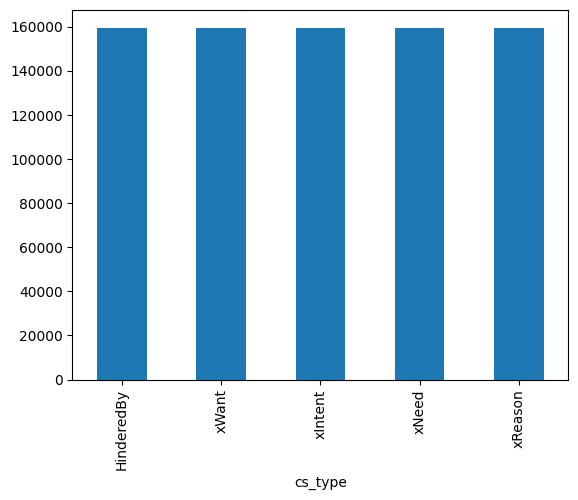

In [10]:
df = pd.read_pickle(pikle_file_paths[0])
selected_comets= np.random.randint(0,26, int(len(df)/25))
preprocessed = df[["sample_id","sentence_id","cs_encoded", "cos_similary_cs_summmary", "cos_similary_cs_sentence", "sentence", "cs_type", "cs"]]

preprocessed['cs_type'].value_counts().plot.bar()